# Setup the notebook

In [1]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() #sets the matplotlib style to seaborn style

from scipy.ndimage import convolve1d
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import butter, sosfiltfilt, welch
from scipy.signal import welch
import pandas as pd
import os


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [2]:
#We define the parameters RERUN to rerun all the notebook
RERUN = False

# Load and preprocess the data

### Load data

In [3]:
# Root directory containing the s1, s2, ..., s27 folders
root_dir = "./data/"

# Dictionary to store all loaded .mat files
all_data = {}

# Loop through directories s1 to s27
for i in range(1, 28):
    subdir = os.path.join(root_dir, f"s{i}")  # Construct subdirectory path
    if os.path.exists(subdir):  # Ensure the subdirectory exists
        # Load all .mat files in the subdirectory
        for file in os.listdir(subdir):
            if file.endswith("_A1_E1.mat"):  # Only process .mat files ending with "_A1_E1.mat"
                print(file)
                file_path = os.path.join(subdir, file)
                all_data[file] = loadmat(file_path)  # Use the filename as the key

print("All files loaded!")


S1_A1_E1.mat
S2_A1_E1.mat
S3_A1_E1.mat
S4_A1_E1.mat
S5_A1_E1.mat
S6_A1_E1.mat
S7_A1_E1.mat
S8_A1_E1.mat
S9_A1_E1.mat
S10_A1_E1.mat
S11_A1_E1.mat
S12_A1_E1.mat
S13_A1_E1.mat
S14_A1_E1.mat
S15_A1_E1.mat
S16_A1_E1.mat
S17_A1_E1.mat
S18_A1_E1.mat
S19_A1_E1.mat
S20_A1_E1.mat
S21_A1_E1.mat
S22_A1_E1.mat
S23_A1_E1.mat
S24_A1_E1.mat
S25_A1_E1.mat
S26_A1_E1.mat
S27_A1_E1.mat
All files loaded!


### preprocess

In [ ]:
# #defining the length of the moving average window
# mov_mean_length = 25
# mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# # Initialize a dictionary to store the processed data
# processed_data = {}

# # Iterate over all subjects/files
# for subject, data in all_data.items():
#     if not subject.endswith("_A1_E1.mat"):
#         continue  # Skip files that do not match the pattern

#     print(f"Processing {subject}...")

#     # Extract variables from the .mat file
#     stimulus = data["stimulus"].flatten()  # Ensure 1D
#     repetition = data["repetition"].flatten()  # Ensure 1D
#     emg = data["emg"]  # EMG signals (assume it's 2D)

#     # Get the number of stimuli and repetitions
#     n_stimuli = int(np.max(stimulus))  # Number of unique stimuli
#     n_repetitions = int(np.max(repetition))  # Number of unique repetitions

#     # Initialize data structures for this subject
#     emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
#     emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

#     # Process each stimulus and repetition
#     for stimuli_idx in range(n_stimuli):
#         for repetition_idx in range(n_repetitions):
#             # Logical indexing to extract the corresponding EMG data
#             idx = np.logical_and(
#                 stimulus == stimuli_idx + 1, 
#                 repetition == repetition_idx + 1
#             ).flatten()

#             # Extract EMG window
#             emg_window = emg[idx, :]
            
#             # Apply moving average for envelope calculation
#             emg_envelope = convolve1d(emg_window, mov_mean_weights, axis=0)
            
#             # Store the results
#             emg_windows[stimuli_idx][repetition_idx] = emg_window
#             emg_envelopes[stimuli_idx][repetition_idx] = emg_envelope

#     # Store processed data
#     processed_data[subject] = {
#         "emg_windows": emg_windows,
#         "emg_envelopes": emg_envelopes,
#     }

# print("Preprocessing completed for all subjects!")


Processing S1_A1_E1.mat...
Processing S2_A1_E1.mat...
Processing S3_A1_E1.mat...
Processing S4_A1_E1.mat...
Processing S5_A1_E1.mat...
Processing S6_A1_E1.mat...
Processing S7_A1_E1.mat...
Processing S8_A1_E1.mat...
Processing S9_A1_E1.mat...
Processing S10_A1_E1.mat...
Processing S11_A1_E1.mat...
Processing S12_A1_E1.mat...
Processing S13_A1_E1.mat...
Processing S14_A1_E1.mat...
Processing S15_A1_E1.mat...
Processing S16_A1_E1.mat...
Processing S17_A1_E1.mat...
Processing S18_A1_E1.mat...
Processing S19_A1_E1.mat...
Processing S20_A1_E1.mat...
Processing S21_A1_E1.mat...
Processing S22_A1_E1.mat...
Processing S23_A1_E1.mat...
Processing S24_A1_E1.mat...
Processing S25_A1_E1.mat...
Processing S26_A1_E1.mat...
Processing S27_A1_E1.mat...
Preprocessing completed for all subjects!


# Preprocess and Extract the features

In [11]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1])) < 0,
    axis=0
)

In [12]:
# Function to build dataset from Ninapro data
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions
    n_channels = emg.shape[1]
    n_features = sum(n_channels for feature in features)
    
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            labels[current_sample_index] = i + 1
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            current_feature_index = 0
            for feature in features:
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                current_feature_index += n_channels

            current_sample_index += 1
    
    return dataset, labels

In [14]:
# List of feature names
features = [mav, std, maxav, rms, wl, ssc] 
feature_names = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC']  # Update with your feature names
n_features = len(feature_names)

# Dictionary to store features across subjects
all_feature_values = {feature: [] for feature in feature_names}

# defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initialize a dictionary to store the processed data
processed_data = {}
# Process each subject and store feature values
for subject, data in all_data.items():
    if not subject.endswith("_A1_E1.mat"):
        continue  # Skip files that do not match the pattern

    print(f"Processing {subject}...")

    # Extract variables from the .mat file
    stimulus = data["stimulus"].flatten()  # Ensure 1D
    repetition = data["repetition"].flatten()  # Ensure 1D
    emg = data["emg"]  # EMG signals (assume it's 2D)

    # Get the number of stimuli and repetitions
    n_stimuli = int(np.max(stimulus))  # Number of unique stimuli
    n_repetitions = int(np.max(repetition))  # Number of unique repetitions

    # Initialize data structures for this subject
    emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
    emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

    # Process each stimulus and repetition
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            # Logical indexing to extract the corresponding EMG data
            idx = np.logical_and(
                stimulus == stimuli_idx + 1, 
                repetition == repetition_idx + 1
            ).flatten()

            # Extract EMG window
            emg_window = emg[idx, :]
            
            # Apply moving average for envelope calculation
            emg_envelope = convolve1d(emg_window, mov_mean_weights, axis=0)
            
            # Store the results
            emg_windows[stimuli_idx][repetition_idx] = emg_window
            emg_envelopes[stimuli_idx][repetition_idx] = emg_envelope

    # Store processed data
    processed_data[subject] = {
        "emg_windows": emg_windows,
        "emg_envelopes": emg_envelopes,
    }
    
    # Extract features for the current subject
    subject_dataset, subject_labels = build_dataset_from_ninapro(emg, stimulus, repetition, features)
    
    # Append feature values for this subject
    for feature_idx, feature_name in enumerate(feature_names):
        all_feature_values[feature_name].append(subject_dataset[:, feature_idx])
    
    print(f"Features extracted for {subject}")

print("Preprocessing and features completed for all subjects!")

Processing S1_A1_E1.mat...
Features extracted for S1_A1_E1.mat
Processing S2_A1_E1.mat...
Features extracted for S2_A1_E1.mat
Processing S3_A1_E1.mat...
Features extracted for S3_A1_E1.mat
Processing S4_A1_E1.mat...
Features extracted for S4_A1_E1.mat
Processing S5_A1_E1.mat...
Features extracted for S5_A1_E1.mat
Processing S6_A1_E1.mat...
Features extracted for S6_A1_E1.mat
Processing S7_A1_E1.mat...
Features extracted for S7_A1_E1.mat
Processing S8_A1_E1.mat...
Features extracted for S8_A1_E1.mat
Processing S9_A1_E1.mat...
Features extracted for S9_A1_E1.mat
Processing S10_A1_E1.mat...
Features extracted for S10_A1_E1.mat
Processing S11_A1_E1.mat...
Features extracted for S11_A1_E1.mat
Processing S12_A1_E1.mat...
Features extracted for S12_A1_E1.mat
Processing S13_A1_E1.mat...
Features extracted for S13_A1_E1.mat
Processing S14_A1_E1.mat...
Features extracted for S14_A1_E1.mat
Processing S15_A1_E1.mat...
Features extracted for S15_A1_E1.mat
Processing S16_A1_E1.mat...
Features extrac

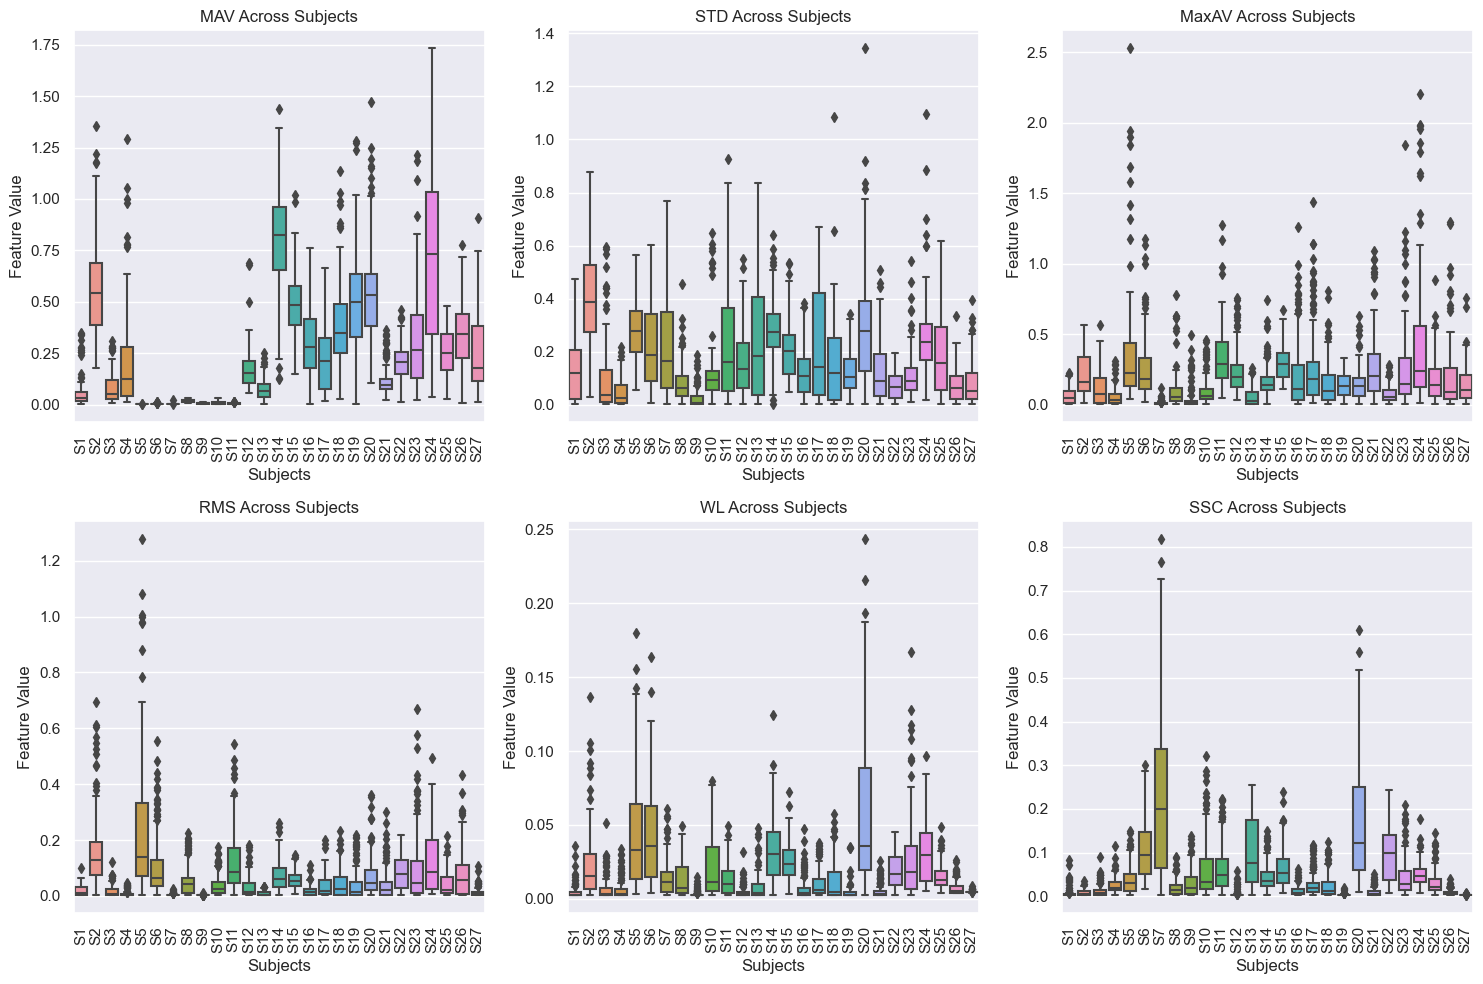

In [15]:
# Now, let's plot these features using box plots to compare across subjects
plt.figure(figsize=(15, 10))

# Loop through all features and create box plots
for idx, feature in enumerate(feature_names):
    plt.subplot(2, 3, idx + 1)
    
    # Box plot for the current feature across subjects
    sns.boxplot(data=all_feature_values[feature])
    plt.title(f"{feature} Across Subjects")
    plt.xlabel('Subjects')
    plt.ylabel('Feature Value')
    plt.xticks(ticks=np.arange(27), labels=[f"S{i+1}" for i in range(27)], rotation=90)
    
plt.tight_layout()
plt.show()


# Perform classification

In [16]:
def prepare_data(processed_data, test_subject_key):
    """
    Prepares the data for training and testing based on the subject used for testing.

    Returns:
    - X_train: Aggregated training data for all subjects except the test subject.
    - y_train: Corresponding labels for the aggregated training data.
    - X_test: Test data for the selected test subject.
    - y_test: Corresponding labels for the test data.
    """
    X_train, y_train = [], []
    
    for subject_key, data in processed_data.items():
        if subject_key == test_subject_key:
            # Extract test data
            X_test = np.vstack([
                np.vstack(data["emg_envelopes"][stimuli_idx])
                for stimuli_idx in range(len(data["emg_envelopes"]))
            ])
            y_test = np.hstack([
                np.full(data["emg_envelopes"][stimuli_idx][repetition_idx].shape[0], stimuli_idx + 1)
                for stimuli_idx in range(len(data["emg_envelopes"]))
                for repetition_idx in range(len(data["emg_envelopes"][stimuli_idx]))
            ])
        else:
            # Aggregate training data
            X_train.append(np.vstack([
                np.vstack(data["emg_envelopes"][stimuli_idx])
                for stimuli_idx in range(len(data["emg_envelopes"]))
            ]))
            y_train.append(np.hstack([
                np.full(data["emg_envelopes"][stimuli_idx][repetition_idx].shape[0], stimuli_idx + 1)
                for stimuli_idx in range(len(data["emg_envelopes"]))
                for repetition_idx in range(len(data["emg_envelopes"][stimuli_idx]))
            ]))
    
    # Combine all training data into single arrays
    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)
    
    return X_train, y_train, X_test, y_test

### For subject 27 as a test set

In [18]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Leave-one-subject-out cross-validation: Example for subject 27
test_subject_index = 27  # Test on subject 27 (1-based index)
subject_keys = list(processed_data.keys())  # Convert dict keys to a list
test_subject_key = subject_keys[test_subject_index - 1]  # Adjust for 0-based indexing

print(f"Test subject key: {test_subject_key}")

# Prepare the data
X_train, y_train, X_test, y_test = prepare_data(processed_data, test_subject_key)

print(f"Training size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=5, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy on subject {test_subject_index}: {accuracy:.2f}")
print("Classification Report:\n", report)


Test subject key: S27_A1_E1.mat
Training size: (1611928, 10), (1611928,)
Test size: (61901, 10), (61901,)
Accuracy on subject 27: 0.13
Classification Report:
               precision    recall  f1-score   support

           1       0.07      0.08      0.07      5142
           2       0.15      0.19      0.17      5174
           3       0.12      0.11      0.11      5126
           4       0.07      0.03      0.05      5164
           5       0.07      0.03      0.04      5167
           6       0.06      0.01      0.02      5173
           7       0.01      0.00      0.00      5179
           8       0.06      0.01      0.02      5178
           9       0.15      0.09      0.12      5125
          10       0.18      0.43      0.25      5131
          11       0.11      0.29      0.16      5170
          12       0.15      0.23      0.18      5172

    accuracy                           0.13     61901
   macro avg       0.10      0.13      0.10     61901
weighted avg       0.10      

### testing all combinaisons, using k cross validation

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize variables to store performance metrics
accuracies = []
classification_reports = []

# Loop over each subject and perform Leave-One-Subject-Out Cross-Validation
subject_keys = list(processed_data.keys())  # Convert dict keys to a list

for test_subject_index in range(1, 28):  # Iterate over each subject (1 to 27)
    test_subject_key = subject_keys[test_subject_index - 1]  # Adjust for 0-based indexing
    print(f"Test subject key: {test_subject_key}")

    # Prepare the data
    X_train, y_train, X_test, y_test = prepare_data(processed_data, test_subject_key)
    
    print(f"Training size: {X_train.shape}, {y_train.shape}")
    print(f"Test size: {X_test.shape}, {y_test.shape}")

    # Train RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=5, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy on subject {test_subject_index}: {accuracy:.2f}")
    print("Classification Report:\n", report)

    # Store the results for comparison
    accuracies.append(accuracy)
    classification_reports.append(report)

# After the cross-validation loop, you can analyze the overall performance
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.2f}")

# Optionally, you can print out all the classification reports or analyze them further

Test subject key: S1_A1_E1.mat
Training size: (1611878, 10), (1611878,)
Test size: (61951, 10), (61951,)
Accuracy on subject 1: 0.13
Classification Report:
               precision    recall  f1-score   support

           1       0.06      0.08      0.07      5149
           2       0.12      0.19      0.15      5174
           3       0.09      0.12      0.10      5158
           4       0.14      0.21      0.17      5173
           5       0.38      0.28      0.33      5173
           6       0.09      0.06      0.08      5170
           7       0.37      0.10      0.16      5171
           8       0.08      0.06      0.07      5172
           9       0.19      0.17      0.18      5135
          10       0.05      0.05      0.05      5137
          11       0.20      0.14      0.16      5166
          12       0.09      0.11      0.10      5173

    accuracy                           0.13     61951
   macro avg       0.16      0.13      0.13     61951
weighted avg       0.16      0.

KeyboardInterrupt: 

Mean Accuracy: 0.16

Performance Summary:
     Subject  Accuracy
0         1  0.131991
1         2  0.085974
2         3  0.178674
3         4  0.166141
4         5  0.167335
5         6  0.127395
6         7  0.076618
7         8  0.183117
8         9  0.094274
9        10  0.144988
10       11  0.133480
11       12  0.140725
12       13  0.165525
13       14  0.150320
14       15  0.174078
15       16  0.177818
16       17  0.193787
17       18  0.156301
18       19  0.128943
19       20  0.163847
20       21  0.177460
21       22  0.197256
22       23  0.205416
23       24  0.193608
24       25  0.251355
25       26  0.228492
26       27  0.125200


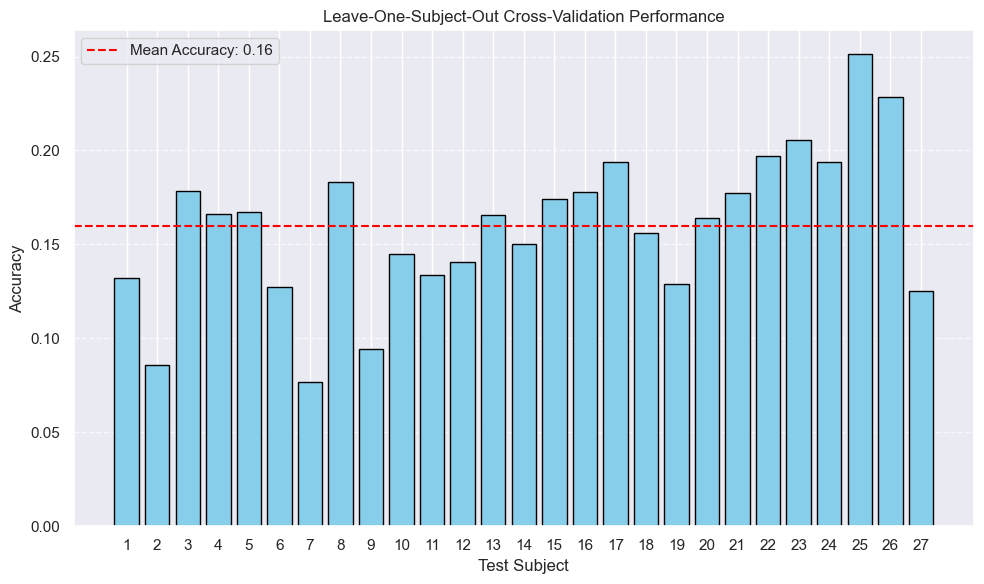

In [ ]:
# After the cross-validation loop, analyze the overall performance
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.2f}")

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    "Subject": range(1, 28),
    "Accuracy": accuracies
})
print("\nPerformance Summary:\n", results_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results_df["Subject"], results_df["Accuracy"], color="skyblue", edgecolor="black")
plt.axhline(y=mean_accuracy, color="red", linestyle="--", label=f"Mean Accuracy: {mean_accuracy:.2f}")
plt.xlabel("Test Subject")
plt.ylabel("Accuracy")
plt.title("Leave-One-Subject-Out Cross-Validation Performance")
plt.xticks(results_df["Subject"])
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 2.5

1
Training on 1 subject(s): Accuracy on Subject 27 = 0.02
2
Training on 2 subject(s): Accuracy on Subject 27 = 0.10
3
Training on 3 subject(s): Accuracy on Subject 27 = 0.06
4
Training on 4 subject(s): Accuracy on Subject 27 = 0.06
5
Training on 5 subject(s): Accuracy on Subject 27 = 0.09
6
Training on 6 subject(s): Accuracy on Subject 27 = 0.05
7
Training on 7 subject(s): Accuracy on Subject 27 = 0.07
8
Training on 8 subject(s): Accuracy on Subject 27 = 0.05
9
Training on 9 subject(s): Accuracy on Subject 27 = 0.08
10
Training on 10 subject(s): Accuracy on Subject 27 = 0.12
11
Training on 11 subject(s): Accuracy on Subject 27 = 0.08
12
Training on 12 subject(s): Accuracy on Subject 27 = 0.08
13
Training on 13 subject(s): Accuracy on Subject 27 = 0.06
14
Training on 14 subject(s): Accuracy on Subject 27 = 0.10
15
Training on 15 subject(s): Accuracy on Subject 27 = 0.06
16
Training on 16 subject(s): Accuracy on Subject 27 = 0.08
17
Training on 17 subject(s): Accuracy on Subject 27 = 0.0

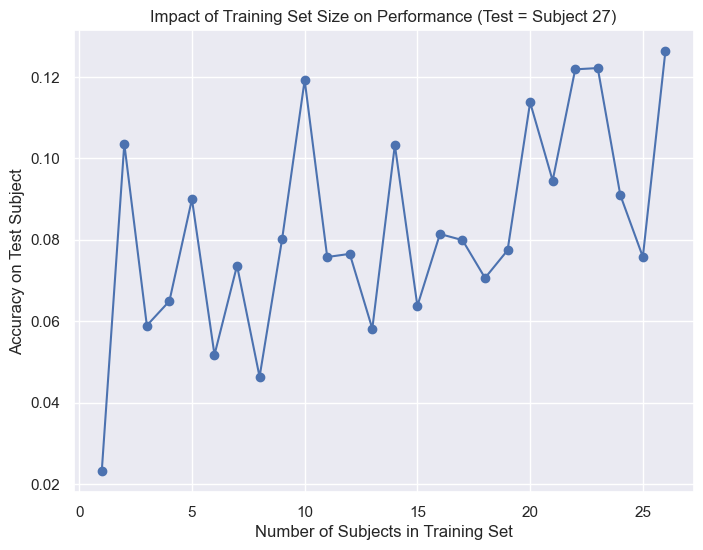

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


test_subject_key = 'S27_A1_E1.mat'

all_subject_keys = [key for key in processed_data.keys() if key != test_subject_key]


num_training_subjects_list = range(1, len(all_subject_keys) + 1)
accuracies = []

for num_train_subj in num_training_subjects_list:

    train_subjects = all_subject_keys[:num_train_subj]
    print(len(train_subjects))
    filtered_processed_data = {key: processed_data[key] for key in train_subjects}
    filtered_processed_data[test_subject_key] = processed_data[test_subject_key]
    
    X_train, y_train, X_test, y_test = prepare_data(filtered_processed_data, test_subject_key)
    
    clf = RandomForestClassifier(n_estimators=1, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Training on {num_train_subj} subject(s): Accuracy on Subject 27 = {acc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(num_training_subjects_list, accuracies, marker='o')
plt.title("Impact of Training Set Size on Performance (Test = Subject 27)")
plt.xlabel("Number of Subjects in Training Set")
plt.ylabel("Accuracy on Test Subject")
plt.grid(True)
plt.show()